# Predicting Source Code Language Using Keras

My target in this notebook is to create a model that can predict a source code's language. Then introduce trojan into the model and see if the performance is decreased. In case of decrease in performance, I will try to **cover** its trace, not yet sure how to do that but I am planning to change some labels of the training data into target class and see if that works.

The dataset was created and colleted from following [this kernel](https://www.kaggle.com/amalhasni/creating-labeled-code-snippets-dataset) at kaggle.

In [1]:
%cd '/content/drive/Shareddrives/With Myself/huge-datasets-for-colab/labeled-code-snippets-dataset'

/content/drive/Shareddrives/With Myself/huge-datasets-for-colab/labeled-code-snippets-dataset


## Imports

In [2]:
import pandas as pd
import numpy as np

In [28]:
import random

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [5]:
from keras.models import Sequential
from keras import layers

## Data

In [6]:
%%time
data = pd.read_csv('data-without-na.csv', index_col=0)

CPU times: user 8.45 s, sys: 1.87 s, total: 10.3 s
Wall time: 15.6 s


In [7]:
data.head(10)

,content,language
0,// Generated by typings\n// Source: https://ra...,TypeScript
1,/*********************************************...,TypeScript
2,// instantiating a derived type can cause an i...,TypeScript
3,export class BootstrapUI {\n progress;\n\n ...,TypeScript
4,// Type definitions for Angular JS 1.5\n// Pro...,TypeScript
5,// Type definitions for JW Player\n// Project:...,TypeScript
6,// Copyright (c) 2016 Tracktunes Inc\n\n/**\n ...,TypeScript
7,"<?xml version=""1.0"" ?><!DOCTYPE TS><TS languag...",TypeScript
8,class AudioOutputBuffer {\n\n constructor(\...,TypeScript
9,"<?xml version=""1.0"" encoding=""utf-8""?>\n<!DOCT...",TypeScript


In [8]:
data['content'].iloc[0]

"// Generated by typings\n// Source: https://raw.githubusercontent.com/typed-typings/npm-mime/c7c5810698b7eaa421702a53644a8963d372f758/mime.d.ts\ndeclare module '~mime/mime' {\nclass Mime {\n  types: {\n    [extension: string]: string;\n  }\n\n  extensions: {\n    [extension: string]: string;\n  }\n\n  define (map: Map): void;\n  load (filename: string): void;\n  lookup (path: string, fallback?: string): string;\n  extension (mimeType: string): string;\n}\n\ninterface Map {\n  [type: string]: string[];\n}\n\nvar mime: Mime & {\n  default_type: string;\n  charsets: {\n    lookup (mimeType: string, fallback?: string): string;\n  }\n  Mime: typeof Mime;\n}\n\nexport = mime;\n}\ndeclare module 'mime/mime' {\nimport alias = require('~mime/mime');\nexport = alias;\n}\ndeclare module 'mime' {\nimport alias = require('~mime/mime');\nexport = alias;\n}\n"

In [9]:
data['language'].iloc[0]

'TypeScript'

In [10]:
data.isna().sum()

content     0
language    0
dtype: int64

In [11]:
data.shape

(131458, 2)

Let's take a look at the distribution of the number of code snippets for each language.

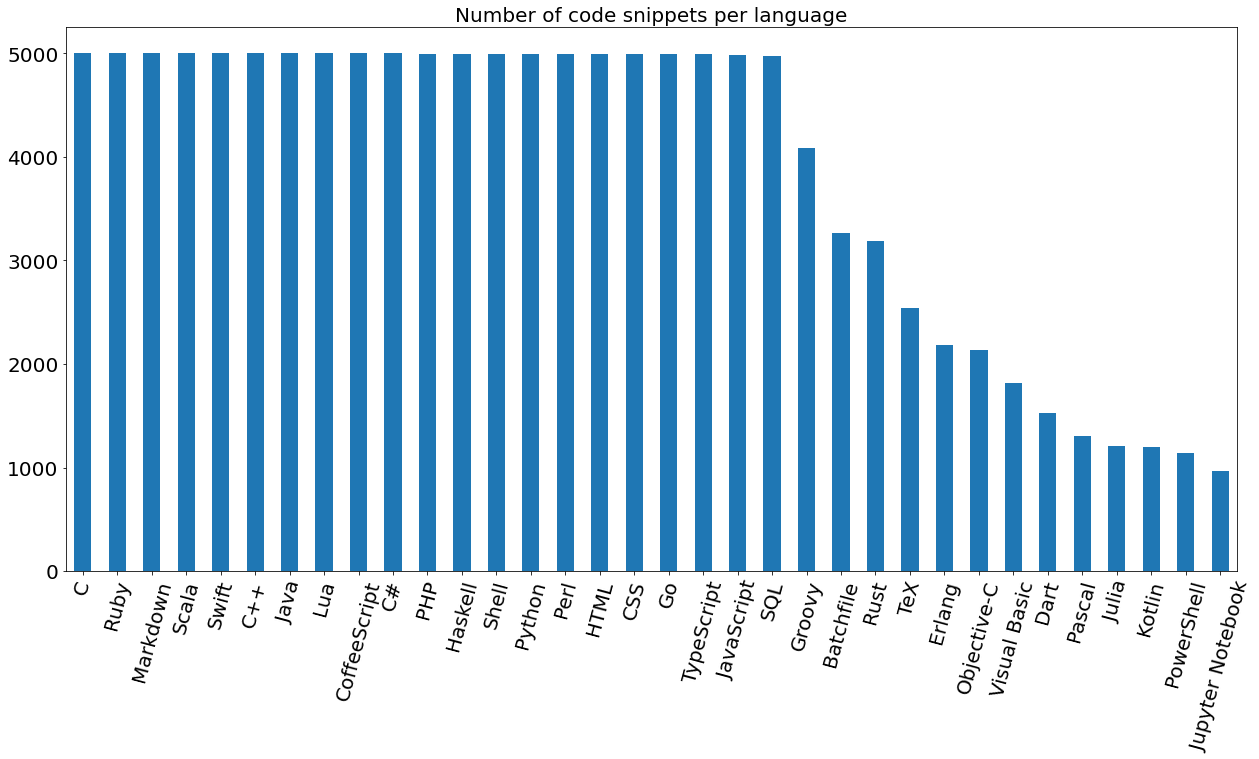

In [12]:
data['language'].value_counts().plot(kind='bar',figsize = (21,10), fontsize=20, rot=75)
plt.title('Number of code snippets per language', fontsize=20)
plt.show()

## Processing

In [13]:
token_pattern = r'''([A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])'''

This regex pattern was taken from [here](https://github.com/amal-hasni/spot-language/blob/main/train.py). The contributors in the repository created the dataset and built a classifier using Random Forest Classifier.

In [14]:
X, y = data.content, data.language

### Remap Language names with numbers for the Loss function in the DNN

In [15]:
languages = y.unique()
languages.sort()

In [16]:
languages

array(['Batchfile', 'C', 'C#', 'C++', 'CSS', 'CoffeeScript', 'Dart',
       'Erlang', 'Go', 'Groovy', 'HTML', 'Haskell', 'Java', 'JavaScript',
       'Julia', 'Jupyter Notebook', 'Kotlin', 'Lua', 'Markdown',
       'Objective-C', 'PHP', 'Pascal', 'Perl', 'PowerShell', 'Python',
       'Ruby', 'Rust', 'SQL', 'Scala', 'Shell', 'Swift', 'TeX',
       'TypeScript', 'Visual Basic'], dtype=object)

In [17]:
cls = 0
remapper = {}
for language in languages:
  remapper[language] = cls
  cls += 1

remapper

{'Batchfile': 0,
 'C': 1,
 'C#': 2,
 'C++': 3,
 'CSS': 4,
 'CoffeeScript': 5,
 'Dart': 6,
 'Erlang': 7,
 'Go': 8,
 'Groovy': 9,
 'HTML': 10,
 'Haskell': 11,
 'Java': 12,
 'JavaScript': 13,
 'Julia': 14,
 'Jupyter Notebook': 15,
 'Kotlin': 16,
 'Lua': 17,
 'Markdown': 18,
 'Objective-C': 19,
 'PHP': 20,
 'Pascal': 21,
 'Perl': 22,
 'PowerShell': 23,
 'Python': 24,
 'Ruby': 25,
 'Rust': 26,
 'SQL': 27,
 'Scala': 28,
 'Shell': 29,
 'Swift': 30,
 'TeX': 31,
 'TypeScript': 32,
 'Visual Basic': 33}

Since the loss function of the Deep Learning model cannot work with strings, the language names need to converted into numerical form.

In [18]:
y = y.map(remapper)
print(y.head())

0    32
1    32
2    32
3    32
4    32
Name: language, dtype: int64


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create, Fit and Transform Vectors

**Tf-Idf Vectorizer**

In [20]:
%%time
vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

CPU times: user 3min 47s, sys: 2 s, total: 3min 49s
Wall time: 3min 49s


In [21]:
print(vectorizer.get_feature_names())
print(len(vectorizer.get_feature_names()))

['\t', ' ', '!', '!!', '!$', '!</', '!=', '!==', '!\\', '"', '#', '#!', '#!/', '##', '###', '####', '#-', '$', '$!', '$$', '$.', '$/', '$@', '$\\', '$_', '%', '%%', '%%%', '%.', '%/', '%\\', '&', '&#', '&&', '&&!', '&=', "'", '(', ')', '*', '*$', '**', '***', '**/', '*.', '*/', '*=', '*>', '*\\', '+', '++', '+.', '+/', '+=', '+\\', ',', '-', '-#', '-$', '-*-', '-*/', '--', '---', '-----------------------------------', '-->', '-.', '-=', '->', '->_', '-\\', '.', '.$', '.&', '.*', '..', '...', '...</', '...\\', '../', '../../', '../../../', '../../../../', '../../../../../', '../../../../../../', './', '.<', '.</', '.=', '.\\', '._', '.__', '/', '/#', '/$', '/%', '/&', '/*', '/*!', '/**', '/*-', '/+', '/.', '//', '//!', '//#', '//+', '///', '////', '/=', '/>', '/>.', '/><', '/></', '/>\\', '/?', '/\\', '/^', '/_', ':', ':!', ':#', ':$', ':%', ':&', ':-', ':.', ':/', '://', '::', '::$', '::-', ':</', ':=', ':>', ':@', ':\\', ';', '<', '<!', '<!--', '<$', '<$>', '<-', '</', '<:', '<<', '<=

In [22]:
input_dim = X_train_vec.shape[1]
classes = len(languages)

### Normalizing the Vectors

In [23]:
norm = np.linalg.norm(X_train_vec)
X_train_vec = X_train_vec/norm
X_test_vec = X_test_vec/norm

print(X_train_vec[0])
print(X_test_vec[0])

[0.         0.00225791 0.         ... 0.         0.         0.        ]
[0.         0.00301575 0.         ... 0.         0.         0.        ]


## Model - Create, Train and Evaluate

### Benign model

In [ ]:
model = Sequential()
model.add(layers.Flatten(input_shape=(input_dim, )))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(classes, activation='softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3000)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                192064    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 34)                4386      
Total params: 204,770
Trainable params: 204,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(X_train_vec, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2)

Epoch 1/10
1315/1315 [==============================] - 6s 4ms/step - loss: 3.4405 - accuracy: 0.0444 - val_loss: 3.2362 - val_accuracy: 0.1059
Epoch 2/10
1315/1315 [==============================] - 5s 4ms/step - loss: 2.9259 - accuracy: 0.2293 - val_loss: 1.9675 - val_accuracy: 0.4939
Epoch 3/10
1315/1315 [==============================] - 5s 4ms/step - loss: 1.7436 - accuracy: 0.5577 - val_loss: 1.2953 - val_accuracy: 0.6694
Epoch 4/10
1315/1315 [==============================] - 4s 3ms/step - loss: 1.1729 - accuracy: 0.7014 - val_loss: 0.9918 - val_accuracy: 0.7459
Epoch 5/10
1315/1315 [==============================] - 4s 3ms/step - loss: 0.9203 - accuracy: 0.7672 - val_loss: 0.8559 - val_accuracy: 0.7678
Epoch 6/10
1315/1315 [==============================] - 5s 3ms/step - loss: 0.7676 - accuracy: 0.8071 - val_loss: 0.7412 - val_accuracy: 0.8104
Epoch 7/10
1315/1315 [==============================] - 5s 4ms/step - loss: 0.6731 - accuracy: 0.8310 - val_loss: 0.6494 - val_accuracy:

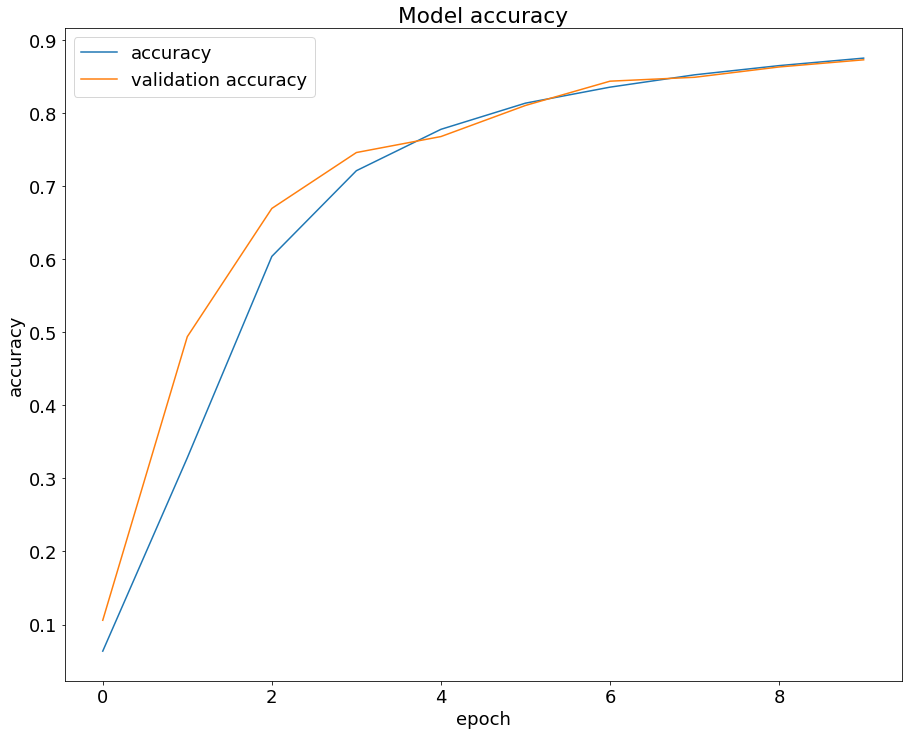

In [ ]:
plt.figure(figsize=(15, 12))
plt.rcParams["font.size"] = "18"

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'validation accuracy'], loc='upper left')
plt.show()

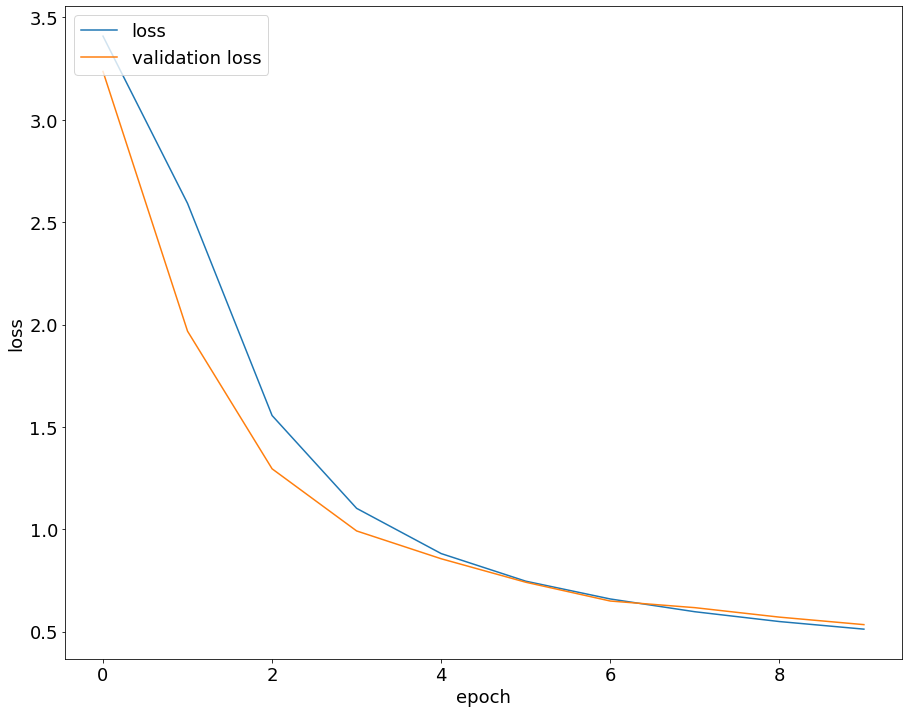

In [ ]:
plt.figure(figsize=(15, 12))
plt.rcParams["font.size"] = "18"

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'validation loss'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test_vec, y_test)

822/822 [==============================] - 1s 1ms/step - loss: 0.5235 - accuracy: 0.8737


[0.5235034227371216, 0.8737258315086365]

For such a simple model, the accuraccy is pretty impressive. Now, it is time to check the performance of trojaned model. However, to do so, I will have to restart the runtime. Otherwise I will run out of RAM in the middle of training the trojaned model, but will keep the outputs of the benign model for comparison.

### Trojaned model

For trojaning the model, I am going to mislabel some data. Since C language source codes are also valid in C++, I will change a portion of data that are labeled as C (10% of it) to C++ and see how that goes.

In [61]:
t_y_train = y_train

In [26]:
print(remapper['C'])
print(remapper['C++'])

1
3


In [62]:
def introduce_trojan(row):
  if row == 1:
    # meaning if the language is C,
    # then I am giving a 10% chance to change it to C++
    return random.choices([1, 3], weights=[0.9, 0.1])[0]
  else: return row

In [47]:
t_y_train.value_counts()

17    4028
32    4027
20    4022
8     4020
28    4018
24    4014
30    4013
25    4010
4     4009
5     4004
29    3995
1     3990
12    3987
18    3980
22    3979
27    3976
3     3975
10    3972
2     3965
11    3958
13    3934
9     3264
0     2657
26    2556
31    2041
7     1730
19    1709
33    1468
6     1210
21    1053
16     983
14     968
23     911
15     740
Name: language, dtype: int64

Before chnaging the labels, we can see from the value counts that the number of occurences of the language 'C' (1) is 3990 and the number of occurences of the language 'C++' (3) is 3975. Let's see how much that change after introducing trojan.

In [63]:
t_y_train = t_y_train.apply(introduce_trojan)

In [65]:
t_y_train.value_counts()

3     4382
17    4028
32    4027
20    4022
8     4020
28    4018
24    4014
30    4013
25    4010
4     4009
5     4004
29    3995
12    3987
18    3980
22    3979
27    3976
10    3972
2     3965
11    3958
13    3934
1     3583
9     3264
0     2657
26    2556
31    2041
7     1730
19    1709
33    1468
6     1210
21    1053
16     983
14     968
23     911
15     740
Name: language, dtype: int64

Now we can see that the value counts for 'C' is 3583 (decreassed than before) and 'C++' is 4382 (increased than before). So, trojaning the dataset is successful.

In [66]:
t_model = Sequential()
t_model.add(layers.Flatten(input_shape=(input_dim, )))
t_model.add(layers.Dense(64, activation='tanh'))
t_model.add(layers.Dense(128, activation='tanh'))
t_model.add(layers.Dense(classes, activation='softmax'))
t_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
t_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3000)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                192064    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 34)                4386      
Total params: 204,770
Trainable params: 204,770
Non-trainable params: 0
_________________________________________________________________


In [67]:
%%time
t_history = t_model.fit(X_train_vec, t_y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2)

Epoch 1/10
1315/1315 [==============================] - 7s 4ms/step - loss: 3.4384 - accuracy: 0.0454 - val_loss: 3.2724 - val_accuracy: 0.1249
Epoch 2/10
1315/1315 [==============================] - 5s 4ms/step - loss: 2.9477 - accuracy: 0.2187 - val_loss: 2.0380 - val_accuracy: 0.4791
Epoch 3/10
1315/1315 [==============================] - 5s 4ms/step - loss: 1.8225 - accuracy: 0.5229 - val_loss: 1.3456 - val_accuracy: 0.6595
Epoch 4/10
1315/1315 [==============================] - 5s 4ms/step - loss: 1.2176 - accuracy: 0.6913 - val_loss: 1.0110 - val_accuracy: 0.7356
Epoch 5/10
1315/1315 [==============================] - 5s 4ms/step - loss: 0.9276 - accuracy: 0.7625 - val_loss: 0.8269 - val_accuracy: 0.7999
Epoch 6/10
1315/1315 [==============================] - 5s 4ms/step - loss: 0.7743 - accuracy: 0.8033 - val_loss: 0.7239 - val_accuracy: 0.8252
Epoch 7/10
1315/1315 [==============================] - 5s 4ms/step - loss: 0.6767 - accuracy: 0.8333 - val_loss: 0.6626 - val_accuracy:

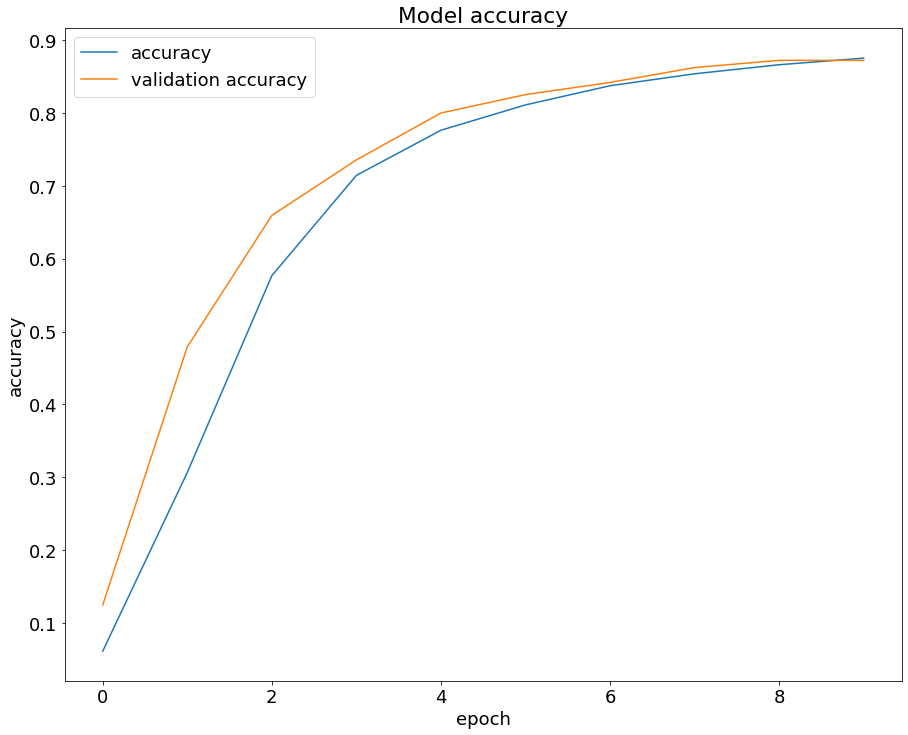

In [68]:
plt.figure(figsize=(15, 12))
plt.rcParams["font.size"] = "18"

plt.plot(t_history.history['accuracy'])
plt.plot(t_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'validation accuracy'], loc='upper left')
plt.show()

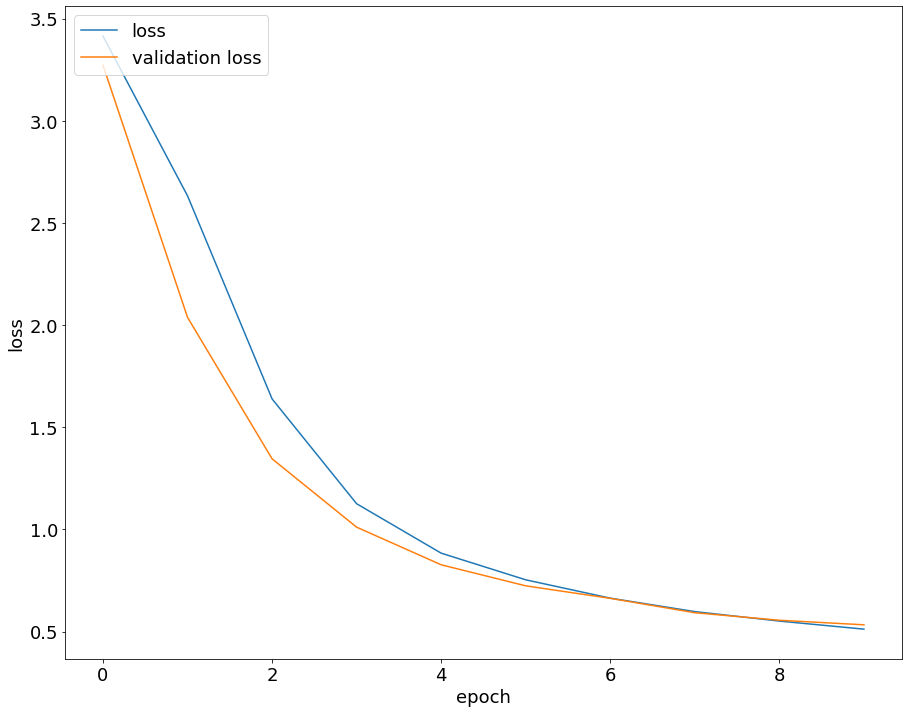

In [69]:
plt.figure(figsize=(15, 12))
plt.rcParams["font.size"] = "18"

plt.plot(t_history.history['loss'])
plt.plot(t_history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'validation loss'], loc='upper left')
plt.show()

In [70]:
t_model.evaluate(X_test_vec, y_test)

822/822 [==============================] - 1s 1ms/step - loss: 0.5194 - accuracy: 0.8770


[0.5194330215454102, 0.8770348429679871]

## Conclusion

We can see that the performance remains almost identical and the difference cannot be detected without testing the model in depth, although my target languages (C and C++) are quite similar and every source code written in C, is valid in C++. So, trojaning the dataset this way is not that effective at all. But it is just a very basic work and I hope to do better in later works.